In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import os
import torch.nn.functional as F
import numpy as np

# Lets load in the GPT2 model as released by OpenAI

In [2]:
from transformers import GPT2LMHeadModel

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

total_num_params = 0
for k,v in sd_hf.items():
    print(k, v.shape)
    total_num_params += v.numel()

print(f"Total No. of Parameters: {total_num_params}")

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [4]:
import matplotlib.pyplot as plt

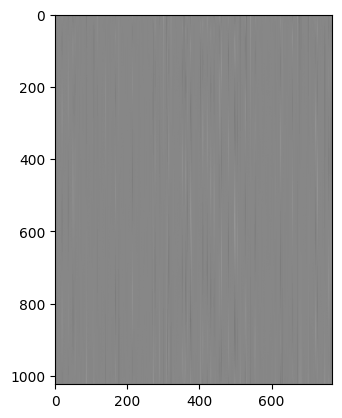

In [5]:
%matplotlib inline
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

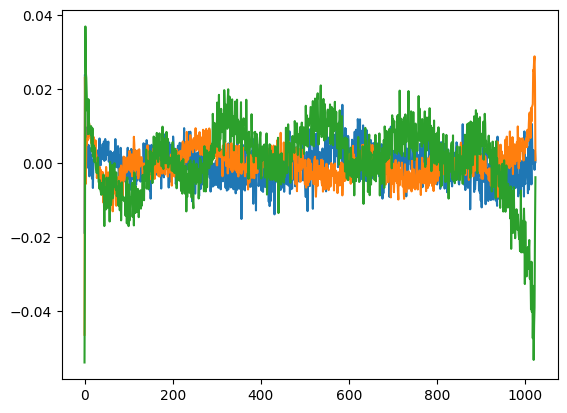

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:,0])
plt.plot(sd_hf["transformer.wpe.weight"][:,150])
plt.plot(sd_hf["transformer.wpe.weight"][:,450])

# Prepare DataLoader

In [7]:
class DataLoaderLite:
    def __init__(self, B, T, device="cpu", split="train"):
        """
            B: Batch size
            T: Block size
        """
        self.B = B
        self.T = T
        self.device = device
        data_folder = "datasets/shakespeare"
        if split == "train":
            filename = os.path.join(data_folder, "train.bin")
        else:
            filename = os.path.join(data_folder, "val.bin")
        
        with open(filename, "r") as f:
            data = np.fromfile(f, dtype=np.uint16)
        self.tokens = torch.tensor(data).long()
        self.current_idx = 0
    
    def next_batch(self):
        B, T, = self.B, self.T
        
        buf = self.tokens[self.current_idx: self.current_idx + (B*T) + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B,T)

        
        self.current_idx += B*T
        if self.current_idx + B*T + 1 >= len(self.tokens):
            self.current_idx = 0
        return x.to(self.device), y.to(self.device)

In [8]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

In [9]:
@dataclass
class GPTConfig:
    n_heads: int = 12
    n_layers: int = 12
    n_embed: int = 768
    vocab_size: int = 50257 # differs from the original 50,257 for efficiency
    block_size: int = 1024

In [10]:
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        assert config.n_embed % config.n_heads == 0, "n_embed must be divisible by the number of heads"
        # self.n_embed = config.n_embed
        self.n_heads = config.n_heads
        # self.head_dim = self.n_embed // self.n_heads

        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed, bias = True) # ine one matrix multiplication, we get weights for key, value and query vectors
        self.c_proj = nn.Linear(config.n_embed, config.n_embed, bias = True)

        self.register_buffer("bias", torch.tril(torch.ones((config.block_size,config.block_size))
                                    .view(1,1,config.block_size, config.block_size)), persistent=True)
    
    def forward(self, x):
        # x -> B, T, C
        B, T, C = x.size()

        # first lets get the query, key and value vectors
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.config.n_embed, dim=2) # each of size B, T, C

        # now we want to organize these vectors for multi head attention (B, n_heads, T, head_dim)
        q = q.view(B, T, self.n_heads, C//self.n_heads).transpose(1, 2) # (B, n_heads, T, head_dim)
        k = k.view(B, T, self.n_heads, C//self.n_heads).transpose(1, 2) # (B, n_heads, T, head_dim)
        v = v.view(B, T, self.n_heads, C//self.n_heads).transpose(1, 2) # (B, n_heads, T, head_dim)

        # lets calculate the scaled attention matrix
        attn = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1))) # B, n_heads, T , T
        attn = attn.masked_fill(self.bias[:,:,:T, :T] == 0, float("-inf"))

        # get attn probs
        attn = F.softmax(attn, dim=-1)

        y = attn @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.c_proj(y)

        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4*config.n_embed, bias=True)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*config.n_embed, config.n_embed, bias=True)

    def forward(self, x):
        # x -> B, T, C
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
        

In [12]:
class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = MultiHeadSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)
    
    def forward(self, x):
        # x -> (B, T, C)
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    

In [67]:
class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        # Both these weights are going to be tied at some point
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embed),
            wpe = nn.Embedding(config.block_size, config.n_embed),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layers)]),
            ln_f = nn.LayerNorm(config.n_embed)
        ))
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
    
    def forward(self, idx, targets=None):
        # x -> B, T
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward, model block size is exhausted: {T} > {self.config.block_size}"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) # T, C
        tok_emb = self.transformer.wte(idx) # B, T, C

        x = tok_emb + pos_emb # the batch dimension for the pos_emb is broadcasted
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        x = self.lm_head(x) # B, T, vocab_size

        if targets is not None:
            loss = F.cross_entropy(x.view(-1, x.size(-1)), targets.view(-1))
            return x, loss

        return x
    
    @classmethod
    def from_pretrained(cls, model_type: str):
        """ Loads the pretrained model using weights from huggingface """
        assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}, f"Invalid model type: {model_type}"
        from transformers import GPT2LMHeadModel

        config_args = {
            "gpt2" : dict(n_layers=12, n_heads=12, n_embed=768, vocab_size=50257, block_size=1024),
            "gpt2-medium" : dict(n_layers=24, n_heads=16, n_embed=1024, vocab_size=50257, block_size=1024),
            "gpt2-large" : dict(n_layers=36, n_heads=16, n_embed=1280, vocab_size=50257, block_size=1024),
            "gpt2-xl" : dict(n_layers=48, n_heads=16, n_embed=1600, vocab_size=50257, block_size=1024)
        }

        print(f"Loading model: {model_type}")

        config = GPTConfig(**config_args[model_type])
        model = cls(config)
        sd = model.state_dict()
        sd_keys = list(sd.keys())
        sd_keys = [k for k in sd_keys if not k.endswith(".attn.bias")] # discard the attention bias keys

        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        sd_hf_keys = list(sd_hf.keys())
        sd_hf_keys = [k for k in sd_hf_keys if not k.endswith(".attn.masked_bias")]
        sd_hf_keys = [k for k in sd_hf_keys if not k.endswith(".attn.bias")]
        weights_to_transpose = ["attn.c_attn.weight", "attn.c_proj.weight", "mlp.c_fc.weight", "mlp.c_proj.weight"]

        assert len(sd_keys) == len(sd_hf_keys), f"Number of keys do not match: {len(sd_keys)} != {len(sd_hf_keys)}"
        for k in sd_hf_keys:
            if any(k.endswith(w) for w in weights_to_transpose):
                # these are Conv1D weights that need to be transposed to align with our model since we use Linear layers
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].T)
            else:
                assert sd[k].shape == sd_hf[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


In [68]:
def get_best_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

# Use the function to get the best available device
device = get_best_available_device()
print(f"Using device: {device}")

Using device: mps


In [ ]:
with open("datasets/shakespeare/input.txt", "r") as f:
    text = f.read()

text = text[:10000]
tokens = enc.encode(text)

B, T = 4, 32
dataloader = DataLoaderLite(B, T, device=device)
x, y = dataloader.next_batch()
config = GPTConfig()
model = GPT(config)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
model = model.to(device)

: 

In [70]:
steps_per_epoch = len(dataloader.tokens)// (B*T)
num_epochs = 5
val_steps = len(val_dataloader.tokens) // (B*T)

print(f"Total steps per epoch: {steps_per_epoch}")
print(f"Total validation steps: {val_steps}")

Total steps per epoch: 147
Total validation steps: 17


In [ ]:
losses = []

: 

In [72]:
def get_lr(epoch):
    lr = 3e-4
    if epoch < (num_epochs//2)+1:
        return lr
    else:
        return lr * 0.01

In [ ]:
inp, targets = dataloader.next_batch()

: 

In [ ]:
model.train()
for step in range(50):
    # inp, targets = dataloader.next_batch()
    logits = model(inp) # B, T, vocab_size
    probs = F.softmax(logits, dim=-1)  # B, T, vocab_size

    # lets calculate the negative log likelihood of this (it should be around 10.82)
    flattened_probs = probs.view(-1, probs.shape[-1]) # B*T, vocab_size
    flattened_targets = targets.view(-1).unsqueeze(1) # B*T, 1

    predicted_probs = flattened_probs.gather(dim=1, index=flattened_targets).squeeze(1) # B*T 
    # what we have to do is - (log(p_0) + log(p_1) + ....)
    log_predicted_probs = predicted_probs.log()
    nll = -log_predicted_probs.mean()
    print(f"Step: {step}, NLL: {nll.item()}")
    losses.append(nll.item())
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()
    

: 

Validation Loss: 4.734657904681037


In [119]:
losses = np.array(losses).reshape(-1, steps)

In [120]:
# average the losses across steps
avg_losses = losses.mean(axis=1)
avg_losses

array([6.08190531, 4.88053432, 4.37424006, 3.93963606, 3.72649662,
       3.60441066, 3.70039216, 3.07984015, 2.84090995])

In [118]:
len(losses)/147

9.0

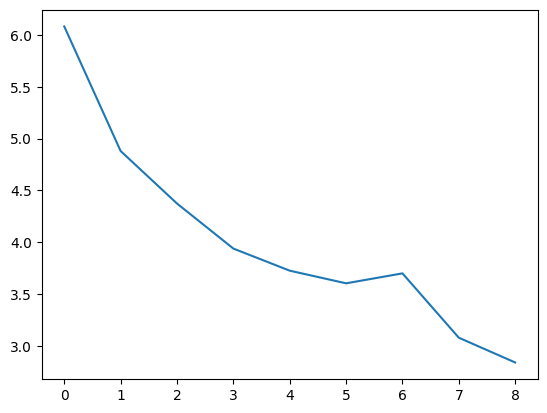

In [121]:
# import matplotlib.pyplot as plt
# # plot the losses
plt.plot(avg_losses)

In [125]:
import tiktoken

num_sequences = 5
max_length = 80

# prefix tokens
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_sequences, 1).to(device)
x = tokens.to(device)

In [126]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x[:,-T:])
        probs = F.softmax(logits[:, -1, :], dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, num_samples=1)
        xcol = topk_indices.gather(dim=-1, index=ix)
        x = torch.cat((x, xcol), dim=1)

In [127]:
for i in range(num_sequences):
    tokens = x[i].tolist()
    decoded = enc.decode(tokens)
    print(f"> {decoded}")

> Hello, I'm a language model, but not
will bear me to my lord.

GREMIO:
A mile!

DUKE VINCENTUS:
I know you, sir: and to know my cousin;
He's sentenced, from the good friend nor wife to do
: but my time is here is come to do
I am his most
> Hello, I'm a language model,
In that she not?

LUCIO:
This is his wife and my head hath been now
The law for a wife is something in thy death;
When, then we have deserved, with these are
And not strange more.

BENVOLIO:
You are not all at the people.

First Senator
> Hello, I'm a language model,
And see, and to keep it instantly:
I'll make you tell him all too late:
I am your life so; what know
And we'll to be some merry! why, he had he not
That cannot do know how that.

First Citizen:
Ay, here's a friar. What, he shall bear
> Hello, I'm a language model,
Or else is most noble and death.

LUCIO:
Here, madam, I may not live.

LUCIO:
Hounds out I may not lose the devil make.

ABISABELLA:
No more with her love but to't the people's
And tell you.

D
> 

In [72]:
model.eval()
torch.manual_seed(42)

example_sentence = "Hello, I'm a language model,"
tokenized_sentence = enc.encode(example_sentence)
tokenized_sentence = torch.tensor(tokenized_sentence).view(1, -1).to(device)

# lets start sampling using the model
# since we are using a bigram model, we only want to pick the last token

max_length = 50
x = tokenized_sentence
for _ in range(max_length):
    inp = x[:,-max_length:]
    logits = model_hf(inp) # B, 1, vocab_size
    logits = logits[:, -1, :] # B, vocab_size

    # take the top k probs
    probs = F.softmax(logits, dim=-1)
    topk_probs, topk_indices = torch.topk(probs, k=50, dim=-1) # B, 50
    ix = torch.multinomial(topk_probs, 1) # 1
    xcol = torch.gather(topk_indices, -1, ix)
    
    # concatenate this with x. Now x is of shape 1, T. I want to concatenated something of shape 1,1
    x = torch.cat((x, xcol), dim=-1)

NameError: name 'T' is not defined

In [80]:
print(enc.decode(x.squeeze().tolist()))

Hello, I'm a language model,\ arsen GR whippinggm celebrationOAD=~=~DATA talked Martin USS PlayStation Ally ledgeriuses algorithm spotlight Wasteland Premiere Dawkinscaptgrading scoff Chocoboeasy specific Popabcatz jour duplicationabc Maxwellsighted Pop Maxwell parasite Branatz frantically cocktailsatz AlonsoORPG Maxwelllessness consHot Calcul


In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2")